# TimeGAN for Time Series Generation 
On this notebook, we’ll get hands-on with using **TimeGAN** model to tackle a generation task. Along the way, you’ll see how the model is built and trained on a specific dataset, and pick up the key ideas so that you can apply them to your own projects with your own data

## Import Libraries

This notebook relies on a set of libraries for time series forecasting and analysis. These include:

- **Pandas / NumPy** for tabular and numerical operations  
- **Hugging Face Datasets** for loading benchmark datasets  
- **Custom `genai4t` utilities** developed for this book to streamline preprocessing, training, and evaluation  
- **Matplotlib** for visualization  

We organize the imports below for clarity.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random
import pandas as pd
from lightning import seed_everything
import torch
from datasets import load_dataset
from genai4t.utils import set_random_state, get_torch_device
from genai4t.data.processing import (
    split_timeseries_with_length,
    dataset_to_pandas
)
from sklearn.model_selection import train_test_split
from genai4t.plot_style import plot_style

## Experiment Configuration

To keep our experiments organized, we define all key parameters (e.g., model hyperparameters, dataset settings, training options) as configuration dictionaries

This allows us to:
- Easily adjust settings in one place
- Avoid hardcoding values throughout the notebook

In [2]:
ENV_CONFIG = {
        'random_state': 2024,
        'use_cuda': True
    }

DATA_CONFIG = {
        'name':  "gatam4t/genai4t_spx_generation",
        'batch_size': 16,
        'sequence_len': 20,
        "num_eval_iterations": 50,
    }

In [3]:
set_random_state(ENV_CONFIG["random_state"])
device = get_torch_device()

Seed set to 2024


## Load Data

In this experiment, we use time series data derived from the **S&P 500 Index (SPX)**, a benchmark index that tracks the performance of 500 of the largest publicly traded companies in the United States. Specifically, the dataset contains two time series:

•⁠  ⁠The log return of the closing price
•⁠  ⁠The log of the Median Realized Volatility

These values span the period from 2005-01-01 to 2020-06-01, and have been standardized to have a mean of 0 and a standard deviation of 1.

The data originates from the [Oxford-Man Realized Volatility Indices dataset](https://github.com/onnokleen/mfGARCH/raw/v0.1.9/data-raw/OxfordManRealizedVolatilityIndices.zip), published by the Oxford-Man Institute of Quantitative Finance (University of Oxford) in collaboration with Man Group, a global active investment management firm. This dataset is widely used in academic research and provides daily realized volatility measures computed from high-frequency intraday financial data.

To make access easier and ensure long-term reproducibility, a copy of the dataset processed has been published in the Hugging Face repo associated with this book. We'll load it directly from there.

While we use this dataset for generation notebooks, the methods in this notebook work with any dataset in wide time series format (i.e., one time series per column) with minimal adjustments.

In [4]:
dataset = load_dataset(DATA_CONFIG["name"], split='train')

# Convert to pandas DataFrame and enforce consistent time frequency
data = dataset_to_pandas(dataset)

# Display the first few rows of the DataFrame
data.head()

,logreturn,logvol
0,-0.979992,0.212416
1,-0.335923,0.438473
2,0.244094,-0.069770
3,-0.132698,0.087008
4,0.257988,-0.278999


In [5]:
# the data have been standardized
data.describe().T

,count,mean,std,min,25%,50%,75%,max
logreturn,3394.0,-3.371860e-09,1.0,-8.298640,-0.356489,0.033435,0.429621,9.072744
logvol,3394.0,-5.934473e-07,1.0,-2.290916,-0.676626,-0.136567,0.602935,4.178672


In [6]:
# transform dataframe into a numpy array
data_as_array = data.to_numpy().astype(np.float32)

In [7]:
data_as_array

array([[-0.979992  ,  0.21241626],
       [-0.33592334,  0.43847257],
       [ 0.24409448, -0.06976987],
       ...,
       [-1.195638  ,  1.0179971 ],
       [ 0.1652753 ,  0.08472553],
       [-0.74991983,  0.80158144]], dtype=float32)

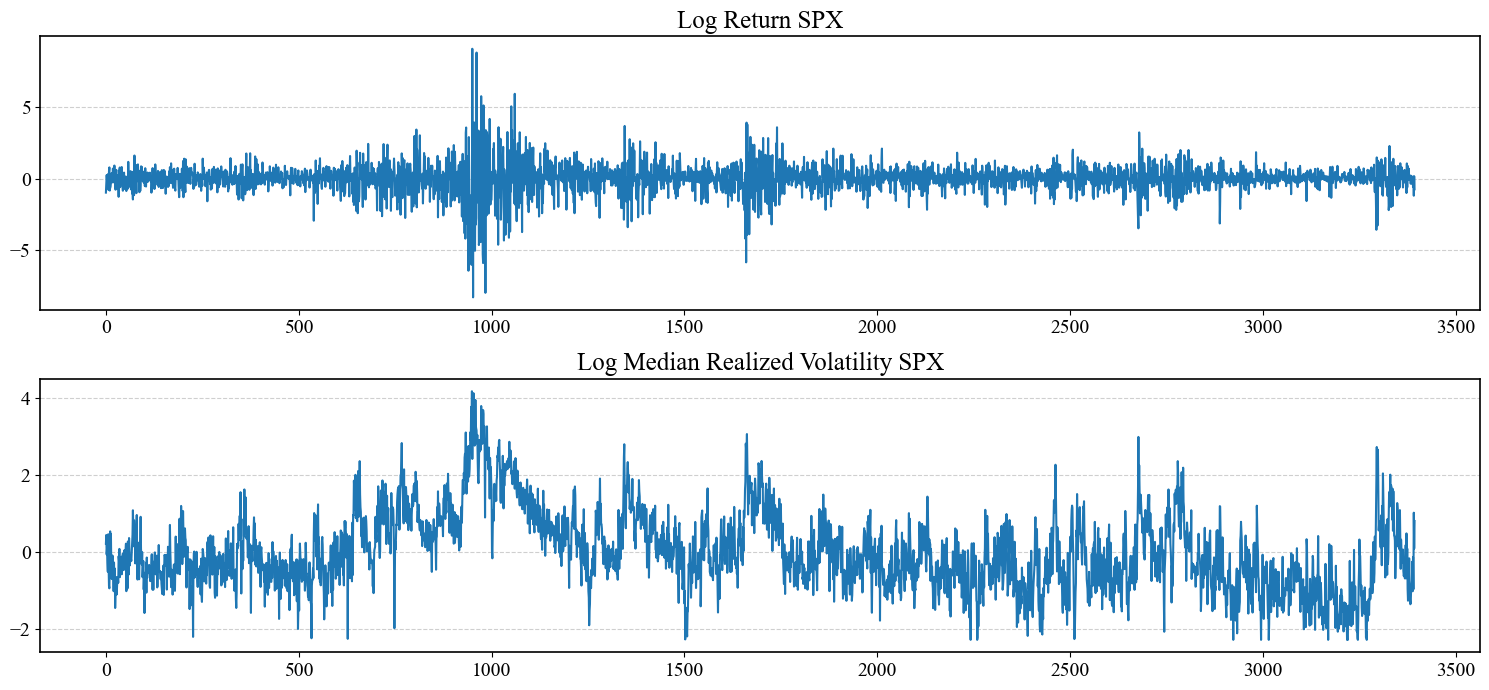

In [8]:
f, axs = plt.subplots(2, 1, figsize=(15, 7))
axs[0].plot(data_as_array[:, 0])
axs[0].set_title("Log Return SPX")
plot_style.apply_plot_style(axs[0])
plot_style.apply_grid(axs[0])
axs[1].plot(data_as_array[:, 1])
axs[1].set_title("Log Median Realized Volatility SPX")
plot_style.apply_plot_style(axs[1])
plot_style.apply_grid(axs[1])

## Sequence Generation

Our models will generate new time series of fixed length `sequence_len`, so we need to transform our historical data into this format. We accomplish this by using the `split_timeseries_with_length` function.

In [9]:
# creates sequence
sequences = split_timeseries_with_length(data_as_array, DATA_CONFIG["sequence_len"])

In [10]:
sequences.shape

(3375, 20, 2)

In [11]:
_, seq_len, feat_dim = sequences.shape 

In [12]:
seq_len

20

In [13]:
feat_dim

2

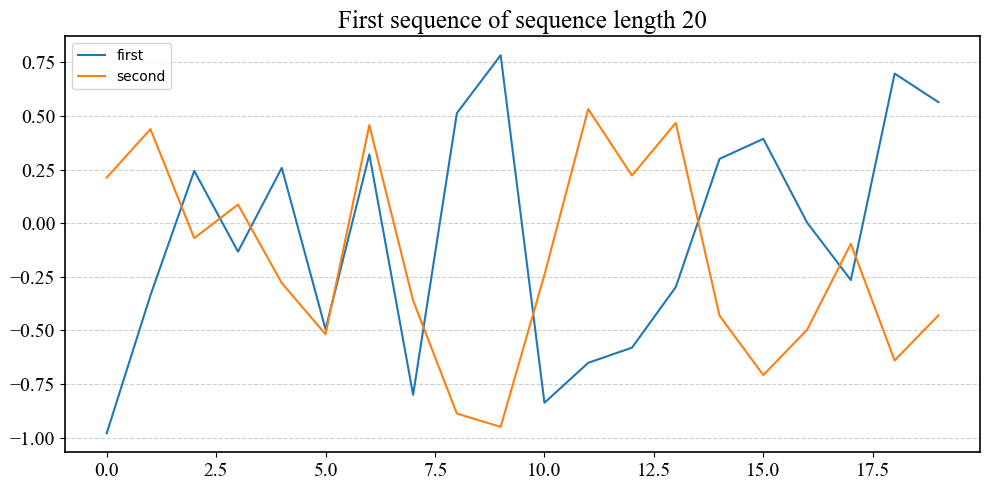

In [14]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(sequences[0, :, 0], label='first')
ax.plot(sequences[0, :, 1], label='second')
plot_style.apply_grid(ax)
ax.set_title(f"First sequence of sequence length {seq_len}")
plot_style.apply_plot_style(ax)
ax.legend()
plt.show()

## Split the Dataset into Train/Test
We split the sequences into training and testing sets, with 20% of the data reserved for testing. To ensure reproducibility, we use the `random_state=ENV_CONFIG["random_state"]` parameter.

In [15]:
train_data, test_data = train_test_split(
    sequences,
    test_size=0.2,
    random_state=ENV_CONFIG["random_state"])

In [16]:
train_data.shape

(2700, 20, 2)

In [17]:
test_data.shape

(675, 20, 2)

## Setting Up the Training Dataloader

We will create a DataLoader using PyTorch's built-in implementation to handle batching.

In [18]:
from torch.utils.data import DataLoader

In [19]:
train_dl = DataLoader(train_data, batch_size=DATA_CONFIG["batch_size"], shuffle=True)

In [20]:
# Number of batches
len(train_dl)

169

In [21]:
# Fetch a single batch from the DataLoader
batch = next(iter(train_dl))
# batch size time series of length sequence_len!
batch.shape

torch.Size([16, 20, 2])

## TimeGAN

[TimeGAN](https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf), see Yoon et al. (2019),  is one of the most elaborate models presented in the book. It serves as an example of how combining different generative modeling techniques can help standard models, such as GANs, better capture the temporal dynamics of time series. This is particularly important when modeling time series at resolutions where dependencies between observations play a critical role.


### The TimeGAN Big Picture 



At the time of its release, TimeGAN introduced a novel framework for generating realistic time series, with the main goal of capturing the temporal dynamics of time series.

What TimeGAN proposes is the following: in addition to using the standard adversarial loss (as in typical GANs), it introduces a mechanism to learn and preserve **time dependent** relationships in the data.

Rather than having the generator create synthetic data directly in the data space, TimeGAN operates in a latent space. Now, as we know, a key element for training GANs is access to real vs. fake data. The fake data comes from the generator, but what about the "real" data in latent space? TimeGAN solves this by using an autoencoder, specifically, the encoder part of the autoencoder, to generate real latent representations.

The encoder compresses the original time series into a lower-dimensional representation (the latent or hidden state), and this is what the GAN tries to mimic. The decoder then reconstructs the signal from latent space back into the data space. In this setup, the generator is trained (via the adversarial loss) to produce realistic hidden states, that when decoded result in plausible time series. In TimeGAN, the generator, discriminator, encoder, and decoder are auto-regressive models, all implemented using RNNs.


However, in order to model the temporal transitions more explicitly, TimeGAN introduces an additional loss, called the **supervised loss**. This loss is designed to capture the step-by-step transitions in the latent space to better align with the transitions in the original time series. For example, the supervised loss measures the difference between the next-step latent state produced by the generator and the corresponding one produced by the encoder. This error signal is then used to drive the generator to model hidden state dynamics. 

As a side note, in some implementations, we've seen the use of an explicit supervised network that takes the synthetic hidden state as input. In practice, this can help the generator better approximate the true hidden state produced by the encoder. In this notebook, we’ll describe and implement the version that uses a supervised network.

So, to summarize:

The model is composed of five networks:

- Two from the autoencoder: the encoder and decoder
- Two from the GAN: the generator and discriminator
- A supervisor network (note: in some implementations, the supervisor network is simply an identity mapping. We leave it to the reader to experiment with different versions.)

And in terms of objectives:

- The supervised objective helps the model learn the dynamics in latent space,
- The adversarial objective pushes the generator to produce realistic samples,
- And both objectives are optimized jointly during training.

This setup is illustrated in the figure below (adapted from Figure 1a in the original paper), which shows the block diagram of component functions and learning objectives. In the diagram:

- Red lines indicate the encoder (Embedding) and decoder (Recovery),
- Blue lines represent the generator (Generate) and discriminator (Discriminate),
- The reconstruction loss defines the latent space,
- The adversarial loss is the usual GAN objective,
- The supervised loss helps the model learn transitions in latent space.



![](./../../assets/figures/chapter08/timegan-paper-figure-1a.png)

Because TimeGAN builds on both GANs and Autoencoders, it's recommended to review Chapters 6 and 8 of the book.

### AutoEncoders Meet GANs


As already mentioned, TimeGAN, like traditional GANs, uses a generator $G$ to create synthetic data and a discriminator $D$ to distinguish real from fake samples. However, unlike standard GANs, TimeGAN doesn’t operate directly in the original data space. Instead, it uses an AutoEncoder to map the data into a hidden space, where the GAN framework is applied.

Let $x$ be a vector in the data space $\mathcal{X}$. Let $z$ be a vector in the vector space $\mathcal{Z}$, over which the random noise is defined. Let $h$ denote a vector representing the hidden state in the latent space $\mathcal{H}$.

Let $E$ be the encoder and $F$ the decoder. The encoder maps the real data $x$ into a hidden representation $h = E(x)$ in the latent space, and the decoder maps generated representations by the generator back to the original data space: $\tilde{x} = F(G(z))$.



### Supervisor: Modeling Temporal Dynamics

TimeGAN adds an additional network called the Supervisor $S$. Its job is to learn the temporal relationships between time steps in the hidden space.

The generator alone can struggle to capture sequential dependencies in time series. The supervisor improves this by transforming the generated hidden states into more realistic sequences: $\hat{h}_s = S(\hat{h})$. These supervised sequences are then passed to the discriminator, allowing it to learn both spatial and temporal distinctions.

### Training

Before diving into the training process, it;s helpful to understand how data moves through the network—specifically, how real data is encoded and decoded, and how synthetic data follows a similar path. This will clarify the training process for the components of the model.

Here’s how data typically flows through the network:


- Sample real data $x \sim p_{\text{data}}$.
- Sample random noise $z \sim p_z$.
- Real data reconstruction: Encode $x$ to hidden space: $h = E(x)$, then decode back to data space $F(h)$:
- Synthetic data reconstruction: Encode $z$ to hidden space: $\hat{h} = G(z)$, apply the supervisor, $\hat{h}_s = S(\hat{h})$, then decode to data space $F(\hat{h}_s)$


Training TimeGAN involves multiple phases:

- pretraining the AutoEncoder
- pretraining the Supervisor
- and finally jointly training all networks.

#### AutoEncoder Pretraining

We start by training the encoder-decoder pair to reconstruct the input data by minimizing the Mean Squared Error (MSE), this is known as the reconstruction loss:

$$
\mathcal{L}_{R} = \sum_{t} ||x_t - F(E(x_t))||^2
$$

#### Supervisor Pretraining
The supervisor is trained to predict the next time step in the latent (hidden) space by minimizing the MSE. Given a sequence of hidden states, where each state is defined as $h_t = E(x_{t})$, it learns to output:

$$
\mathcal{L}_{S} = \sum_{t}||h_{t+1} - S(h_t)||^2
$$
this is called the supervised loss. The supervisor is also an RNN network. 

#### Jointly training

After pretraining, we train all components together using the following objectives:

**Discriminator loss**: The discriminator loss is the same as in regular GANs. It minimizes the negative log-likelihood of correctly classifying both real and fake samples.

$$
\mathcal{L}_D = - \sum_t \log D(E(x_t)) - \sum_{t'} \log{(1 - D(S(G(z_{t'})))}
$$

**Generator loss**: The generator is trained to fool the discriminator into classifying generated sequences as real by minimizing the following objective:

$$
\mathcal{L}_G = - \sum_{t'} \log(D(S(G(z_{t'})))
$$

Additionally, we continue training the encoder, decoder, and supervisor jointly with the generator and discriminator networks, using the same objectives as in the pretraining phase.
We also add a moment loss that matches the mean and variance between the real and generated data.

The full loss is a weighted combination of all these objectives, as shown in the code below.

### Data generation process
Once we assume that all five networks have been trained, how do we generate time series samples? The process is as follows:

1. Sample random noise $z \sim p_z$.
2. Generate synthetic hidden representation using the generator: $\hat{h} = G(z)$.
3. Apply the supervisor, $\hat{h}_s = S(\hat{h})$
4. Decode $\hat{h}_s$ back to the original data space: $\tilde{x} = F(\hat{h}_s)$.

### Implementation

In [22]:
from torch import nn
import torch
import itertools
import torch
from torch import nn
from genai4t.chapters.gans.core import (
    BaseGanModule,
    BaseLightningModule)
from genai4t.model.utils import SampleTimeSeries

MSELoss = nn.MSELoss()


def compute_supervisor_loss(h_hat: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
    """
    Compute the supervisor loss for temporal dynamics prediction.
    
    Args:
        h_hat: Predicted hidden states
        h: True hidden states
        
    Returns:
        torch.Tensor: Mean squared error loss between predicted and true next states
    """
    return MSELoss(h_hat[:, :-1, :], h[:, 1:, :])


class PretrainAEModule(BaseLightningModule):
    """
    Autoencoder module for pretraining the embedding network.
    
    This module pretrains the encoder and decoder to learn meaningful temporal embeddings
    of the input time series data.
    
    Attributes:
        encoder (nn.Module): Neural network for encoding time series data
        decoder (nn.Module): Neural network for decoding embeddings back to time series
        lr (float): Learning rate for optimization
        weight_decay (float): Weight decay for optimization
    """
    
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
        lr: float = 1e-3,
        weight_decay: float = 0.):
        super().__init__(lr=lr, weight_decay=weight_decay)
        
        self.encoder = encoder
        self.decoder = decoder

    def step(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform a single training step.
        
        Args:
            x: Input time series data
            
        Returns:
            torch.Tensor: Reconstruction loss
        """
        h = self.encoder(x)
        reconstructed_x = self.decoder(h)

        reconst_loss = MSELoss(reconstructed_x, x)
        return reconst_loss


class PretrainSupervisorModule(BaseLightningModule):
    """
    Supervisor module for pretraining temporal dynamics.
    
    This module pretrains the supervisor network to learn the temporal dynamics
    of the embedded time series data.
    
    Attributes:
        encoder (nn.Module): Fixed encoder network
        supervisor (nn.Module): Network for learning temporal dynamics
        lr (float): Learning rate for optimization
        weight_decay (float): Weight decay for optimization
    """
    
    def __init__(
        self,
        encoder: nn.Module,
        supervisor: nn.Module,
        lr: float = 1e-3,
        weight_decay: float = 0.):
        super().__init__(lr=lr, weight_decay=weight_decay)

        self.encoder = encoder
        self.supervisor = supervisor

    def step(self, x: torch.Tensor) -> torch.Tensor:
        """
        Perform a single training step.
        
        Args:
            x: Input time series data
            
        Returns:
            torch.Tensor: Supervisor loss
        """
        h = self.encoder(x)
        h_supervised = self.supervisor(h)
        loss = compute_supervisor_loss(h_supervised, h)
        return loss

    def configure_optimizers(self):
        """
        Configure optimizer for training.
        
        Only the supervisor parameters are optimized, while the encoder remains fixed.
        
        Returns:
            torch.optim.Optimizer: Adam optimizer for the supervisor
        """
        optimizer = torch.optim.Adam(
            self.supervisor.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay)
        return optimizer


def get_generator_moment_loss(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """
    Compute moment loss to preserve statistical properties of generated data.
    
    This loss ensures that the generated time series maintains similar statistical
    properties (mean and variance) as the real data.
    
    Args:
        y_true: Real time series data
        y_pred: Generated time series data
        
    Returns:
        torch.Tensor: Combined loss of mean and variance differences
    """
    y_true_mean = torch.mean(y_true, dim=0)
    y_true_var = torch.var(y_true, dim=0, unbiased=False)
    
    y_pred_mean = torch.mean(y_pred, dim=0)
    y_pred_var = torch.var(y_pred, dim=0, unbiased=False)
    
    # Compute mean absolute difference between means
    g_loss_mean = torch.mean(torch.abs(y_true_mean - y_pred_mean))
    
    # Compute mean absolute difference between standard deviations
    g_loss_var = torch.mean(torch.abs(torch.sqrt(y_true_var + 1e-6) - torch.sqrt(y_pred_var + 1e-6)))
    
    return g_loss_mean + g_loss_var


class TimeGanModule(BaseGanModule):
    """
    Main TimeGAN module implementing the complete training framework.
    
    This class combines all components (autoencoder, supervisor, generator, discriminator)
    and implements the complete TimeGAN training procedure.
    
    Attributes:
        encoder (nn.Module): Network for encoding time series data
        decoder (nn.Module): Network for decoding embeddings
        supervisor (nn.Module): Network for learning temporal dynamics
        generator (nn.Module): Network for generating synthetic data
        discriminator (nn.Module): Network for discriminating real vs. synthetic data
        sampler (SampleTimeSeries): Utility for sampling noise vectors
        gamma (float): Weight for discriminator loss components
        lr (float): Learning rate for optimization
        weight_decay (float): Weight decay for optimization
        discriminator_steps (int): Number of discriminator steps per training iteration
        generator_steps (int): Number of generator steps per training iteration
        discriminator_warmup (int): Number of warmup steps for discriminator
    """
    
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
        supervisor: nn.Module,
        generator: nn.Module, 
        discriminator: nn.Module,
        sampler: SampleTimeSeries,
        gamma: float = 1.,
        lr: float = 1e-3,
        weight_decay: float = 0.,
        discriminator_steps: int = 5,
        generator_steps: int = 5,
        discriminator_warmup: int = 50):
        super().__init__(
            lr=lr,
            weight_decay=weight_decay,
            discriminator_steps=discriminator_steps,
            generator_steps=generator_steps,
            discriminator_warmup=discriminator_warmup,
        )

        self.encoder = encoder
        self.decoder = decoder
        self.supervisor = supervisor
        self.generator = generator
        self.discriminator = discriminator
        self.sampler = sampler

        self._bce_loss = nn.BCELoss()
        self.gamma = gamma

    def configure_optimizers(self):
        generator_opt = torch.optim.Adam(
            itertools.chain(
                self.generator.parameters(),
                self.supervisor.parameters()
            ),
            lr=self.lr,
            weight_decay=self.weight_decay)

        autoencoder_opt = torch.optim.Adam(
            itertools.chain(
                self.encoder.parameters(),
                self.decoder.parameters()
            ),
            lr=self.lr,
            weight_decay=self.weight_decay)

        discriminator_opt = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay)

        return [generator_opt, autoencoder_opt, discriminator_opt], []

    def discriminator_step(
        self,
        x: torch.Tensor,
        z: torch.Tensor,
        discriminator_opt: torch.optim.Optimizer) -> torch.Tensor:
        """
        Perform a single discriminator training step.
        
        Args:
            x: Real time series data
            z: Random noise vector
            discriminator_opt: Discriminator optimizer
            
        Returns:
            torch.Tensor: Discriminator loss
        """
        self.toggle_optimizer(discriminator_opt)

        h = self.encoder(x)
        e_hat = self.generator(z)
        h_hat = self.supervisor(e_hat)

        y_fake = self.discriminator(h_hat)
        y_fake_e = self.discriminator(e_hat)
        y_real = self.discriminator(h)

        d_real_loss = self._bce_loss(y_real, torch.ones_like(y_real))
        d_fake_loss = self._bce_loss(y_fake, torch.zeros_like(y_fake))
        d_fake_e_loss = self._bce_loss(y_fake_e, torch.zeros_like(y_fake_e))
        d_loss = d_real_loss + d_fake_loss + self.gamma * d_fake_e_loss

        # backward
        self.manual_backward(d_loss) 
        # update parameters
        discriminator_opt.step()
        # reset grads
        discriminator_opt.zero_grad()
        # unset optimizer
        self.untoggle_optimizer(discriminator_opt)

        return d_loss

    def generator_step(
        self,
        x: torch.Tensor,
        z: torch.Tensor,
        generator_opt: torch.optim.Optimizer) -> torch.Tensor:
        """
        Perform a single generator training step.
        
        Args:
            x: Real time series data
            z: Random noise vector
            generator_opt: Generator optimizer
            
        Returns:
            torch.Tensor: Generator loss
        """
        self.toggle_optimizer(generator_opt)

        # FIXED
        h = self.encoder(x)

        # generator, supervisor
        h_hat_supervised = self.supervisor(h)

        # FIXED
        generator_loss_supervised = compute_supervisor_loss(h_hat_supervised, h)

        e_hat = self.generator(z)
        y_fake_e = self.discriminator(e_hat)
        # adversiral loss
        generator_loss_unsupervised_e = self._bce_loss(y_fake_e, torch.ones_like(y_fake_e))


        h_hat = self.supervisor(e_hat)
        y_fake = self.discriminator(h_hat)
        # adversiral loss
        generator_loss_unsupervised = self._bce_loss(y_fake, torch.ones_like(y_fake))

        # ????
        x_hat = self.decoder(h_hat)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)


        generator_loss = (
            generator_loss_unsupervised +
            generator_loss_unsupervised_e +
            100 * torch.sqrt(generator_loss_supervised) +
            100 * generator_moment_loss)


        self.manual_backward(generator_loss)
        # update parameters
        generator_opt.step()
        # zero grad
        generator_opt.zero_grad()
        # untoggle
        self.untoggle_optimizer(generator_opt)
        return generator_loss


    def ae_step(
        self,
        x: torch.Tensor,
        autoencoder_opt: torch.optim.Optimizer) -> torch.Tensor:
        """
        Perform a single autoencoder training step.
        
        Args:
            x: Real time series data
            autoencoder_opt: Autoencoder optimizer
            
        Returns:
            torch.Tensor: Autoencoder loss
        """
        self.toggle_optimizer(autoencoder_opt)

        # VARIABLE
        h = self.encoder(x)

        # FIXED
        h_supervised = self.supervisor(h)

        # VARIABLE
        reconstructed_x = self.decoder(h)

        # FIXED
        supervisor_loss_supervised = compute_supervisor_loss(h_supervised, h)

        # RECONSTRUCTION
        embedding_loss_t0 = MSELoss(reconstructed_x, x)

        e_loss = 10 * torch.sqrt(embedding_loss_t0) + 0.1 * supervisor_loss_supervised  

        self.manual_backward(e_loss)
        # update parameters
        autoencoder_opt.step()
        # zero grad
        autoencoder_opt.zero_grad()
        # untoggle
        self.untoggle_optimizer(autoencoder_opt)  

        return e_loss

    def step(
        self,
        x: torch.Tensor,
        train_discriminator: bool = True,
        train_generator: bool = True
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Perform a complete training step.
        
        Args:
            x: Real time series data
            train_discriminator: Whether to train the discriminator
            train_generator: Whether to train the generator
            
        Returns:
            tuple[torch.Tensor, torch.Tensor]: Generator loss and discriminator loss
        """
        generator_opt, autoencoder_opt, discriminator_opt = self.optimizers()
        z = self.sampler.sample(x.size(0)).to(x.device)

        generator_loss = discriminator_loss = None
        if train_generator:
            gen_loss = self.generator_step(x=x, z=z, generator_opt=generator_opt)
            ae_loss = self.ae_step(x, autoencoder_opt=autoencoder_opt)
            generator_loss = gen_loss + ae_loss

        if train_discriminator:
            discriminator_loss = self.discriminator_step(x=x, z=z, discriminator_opt=discriminator_opt)

        return generator_loss, discriminator_loss


All the network in this architecture are based on Recurrent Neural Networs, specifically, using `GRU` Layers.

In [23]:
from genai4t.model.layers import GRULayer
from genai4t.model.utils import fit_model, init_linear_weights, SampleTimeSeries

In [24]:
# Define model configuration parameters
MODEL_CONFIG = {
    'z_dim': 2, # Dimensionality of the noise space,
    'hidden_dim': 24,  # Dimensionality of latent space
    'n_features_in_gru': 24,
    'num_layers': 1, # Number of RNN layers used in each network
    'lr': 0.001, # Learning rate for joint traning
    'pretrain_lr': 1e-2, # Learning rate for the pretraining phases
    'model_dir': './artifacts/timegan', # Directory to save model artifacts
    'steps': 100 * 169,  # Number of steps for joint model training
    'pretrain_steps': 4_000, # Number of steps for pretraining (autoencoder/supervisor)
}

In [25]:
# Define the embedder network (encoder), which maps real data into the latent space.

embedder = GRULayer(
    input_dim=feat_dim,
    hidden_dim=MODEL_CONFIG["n_features_in_gru"],
    target_dim=MODEL_CONFIG["hidden_dim"],
    num_layers=MODEL_CONFIG["num_layers"],
    act_fn=None).apply(init_linear_weights)

# Define the recovery network (decoder), which reconstructs data from the latent space.
recovery = GRULayer(
    input_dim=MODEL_CONFIG["hidden_dim"],
    hidden_dim=MODEL_CONFIG["n_features_in_gru"],
    target_dim=feat_dim,
    num_layers=MODEL_CONFIG["num_layers"],
    act_fn=None).apply(init_linear_weights)

In [26]:
embedder

GRULayer(
  (rnn): GRU(2, 24, batch_first=True)
  (mlp): Linear(in_features=24, out_features=24, bias=True)
)

In [27]:
recovery

GRULayer(
  (rnn): GRU(24, 24, batch_first=True)
  (mlp): Linear(in_features=24, out_features=2, bias=True)
)

### AutoEncoder Pretraining

In [28]:
# Define the number of pretraining steps for the autoencoder
PRETRAIN_STEPS = 4_000

In [29]:
PRETRAIN_STEPS

4000

In [30]:
# Initialize the autoencoder pretraining module
# This combines the embedder (encoder) and recovery (decoder) networks
ae = PretrainAEModule(encoder=embedder, decoder=recovery, lr=MODEL_CONFIG["pretrain_lr"])

Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | encoder | GRULayer | 2.6 K  | train
1 | decoder | GRULayer | 3.6 K  | train
---------------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


total_n_params: 6266
deleting ./artifacts/timegan/ae..


/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=4000` reached.


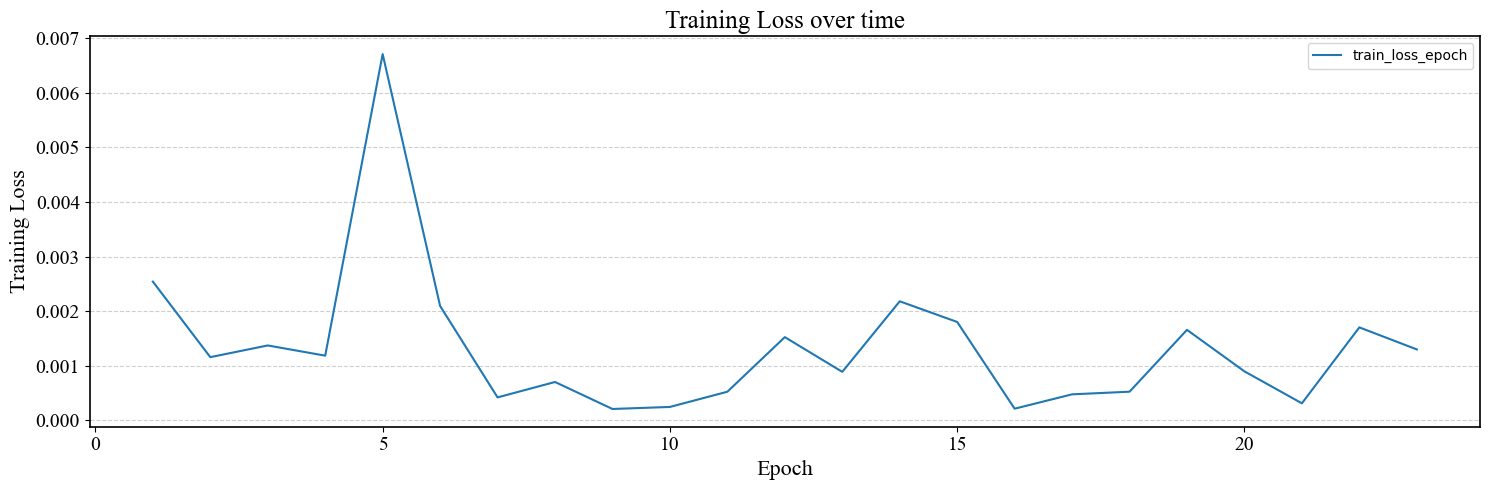

In [31]:
# Set up a logging directory to store autoencoder pretraining results
ae_log_dir = os.path.join(MODEL_CONFIG["model_dir"], 'ae')

# Train the autoencoder using the fit_model utility
trainer = fit_model(
    logdir=ae_log_dir,
    model=ae,
    train_dl=train_dl,
    num_steps=MODEL_CONFIG["pretrain_steps"],
    random_state=ENV_CONFIG["random_state"])

### Supervisor Pretraining

In [32]:
# Define the Supervisor network
supervisor = GRULayer(
    input_dim=MODEL_CONFIG["hidden_dim"],
    hidden_dim=MODEL_CONFIG["n_features_in_gru"],
    target_dim=MODEL_CONFIG["hidden_dim"],
    num_layers=MODEL_CONFIG["num_layers"],
    act_fn=None).apply(init_linear_weights)

In [33]:
# Initialize the pretraining module for the Supervisor network
supervisor_module = PretrainSupervisorModule(
    encoder=embedder, 
    supervisor=supervisor, 
    lr=MODEL_CONFIG["pretrain_lr"])

Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name       | Type     | Params | Mode 
------------------------------------------------
0 | encoder    | GRULayer | 2.6 K  | train
1 | supervisor | GRULayer | 4.2 K  | train
------------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


total_n_params: 6816
deleting ./artifacts/timegan/supervisor..


/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=4000` reached.


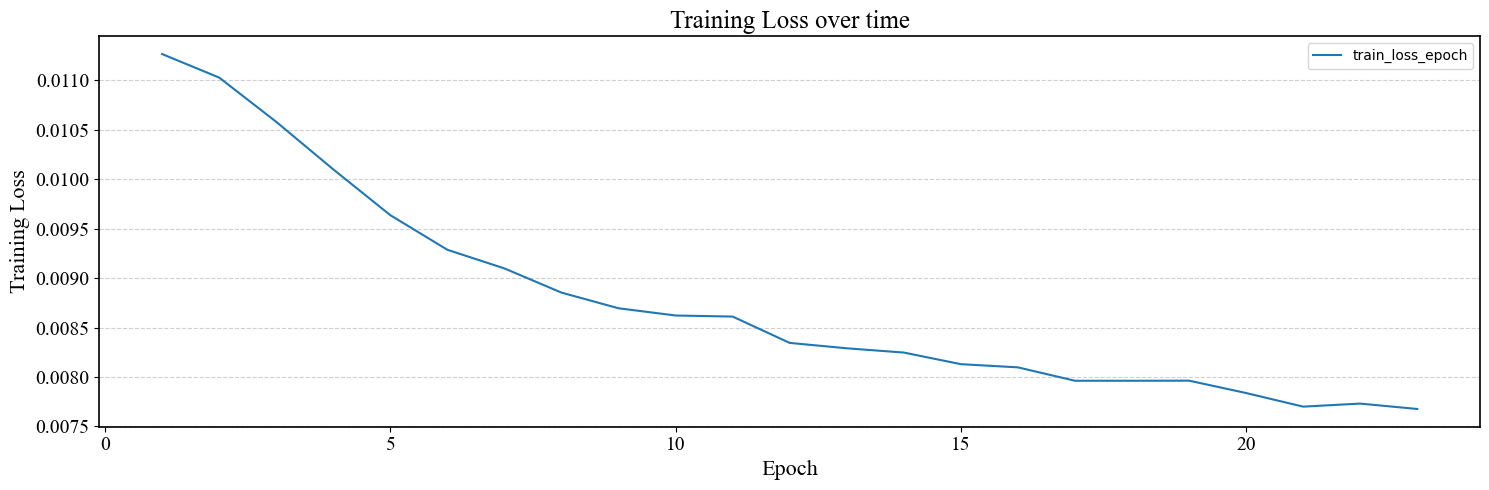

In [34]:
# Set up the directory to store logs
supervisor_log_dir = os.path.join(MODEL_CONFIG["model_dir"], 'supervisor')

# Train the supervisor network using the fit_model utility
trainer = fit_model(
    logdir=supervisor_log_dir,
    model=supervisor_module,
    train_dl=train_dl,
    num_steps=MODEL_CONFIG["pretrain_steps"],
    random_state=ENV_CONFIG["random_state"])

### Jointly training all networks

In [35]:
# Define the Generator network
generator = GRULayer(
    input_dim=MODEL_CONFIG['z_dim'],
    hidden_dim=MODEL_CONFIG["n_features_in_gru"],
    target_dim=MODEL_CONFIG["hidden_dim"],
    num_layers=MODEL_CONFIG["num_layers"], 
    act_fn=None).apply(init_linear_weights)
# Define the Discriminator network
discriminator = GRULayer(
    input_dim=MODEL_CONFIG["hidden_dim"],
    hidden_dim=MODEL_CONFIG["n_features_in_gru"],
    target_dim=1,
    num_layers=MODEL_CONFIG["num_layers"]).apply(init_linear_weights)

In [36]:
generator

GRULayer(
  (rnn): GRU(2, 24, batch_first=True)
  (mlp): Linear(in_features=24, out_features=24, bias=True)
)

In [37]:
discriminator

GRULayer(
  (rnn): GRU(24, 24, batch_first=True)
  (mlp): Linear(in_features=24, out_features=1, bias=True)
  (act_fn): Sigmoid()
)

In [38]:
supervisor

GRULayer(
  (rnn): GRU(24, 24, batch_first=True)
  (mlp): Linear(in_features=24, out_features=24, bias=True)
)

In [39]:
# Create a sampler to generate random sequences from a standard normal distribution

sampler = SampleTimeSeries(seq_len, MODEL_CONFIG['z_dim'])

In [40]:
# Initialize the full TimeGAN model with all five components:
# - embedder: encoder for mapping data to latent space
# - recovery: decoder for reconstructing data from latent space
# - supervisor: models temporal transitions in latent space
# - generator: generates synthetic latent sequences
# - discriminator: distinguishes real from synthetic latent sequences
# - sampler: samples noise for generator input
timegan = TimeGanModule(
    embedder,
    recovery,
    supervisor,
    generator,
    discriminator,
    sampler)

In [41]:
# Set up the directory to store logs 
gan_log_dir = os.path.join(MODEL_CONFIG["model_dir"], 'gan')
# Train the full TimeGAN model using the fit_model utility
trainer = fit_model(
    logdir=gan_log_dir,
    model=timegan,
    train_dl=train_dl,
    num_steps=MODEL_CONFIG["steps"],
    random_state=ENV_CONFIG["random_state"],
    plot=False)


Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | encoder       | GRULayer         | 2.6 K  | train
1 | decoder       | GRULayer         | 3.6 K  | train
2 | supervisor    | GRULayer         | 4.2 K  | train
3 | generator     | GRULayer         | 2.6 K  | train
4 | discriminator | GRULayer         | 3.6 K  | train
5 | sampler       | SampleTimeSeries | 0      | train
6 | _bce_loss     | BCELoss          | 0      | tra

total_n_params: 16707
deleting ./artifacts/timegan/gan..


/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=16900` reached.


## Unconditional Generation
We will sample latent vectors from a standard normal distribution $p_z =\mathcal{N}(0, I)$ and use the generator and supervisor networks to produce new time series

In [42]:
timegan.eval()
timegan.to(device)

TimeGanModule(
  (encoder): GRULayer(
    (rnn): GRU(2, 24, batch_first=True)
    (mlp): Linear(in_features=24, out_features=24, bias=True)
  )
  (decoder): GRULayer(
    (rnn): GRU(24, 24, batch_first=True)
    (mlp): Linear(in_features=24, out_features=2, bias=True)
  )
  (supervisor): GRULayer(
    (rnn): GRU(24, 24, batch_first=True)
    (mlp): Linear(in_features=24, out_features=24, bias=True)
  )
  (generator): GRULayer(
    (rnn): GRU(2, 24, batch_first=True)
    (mlp): Linear(in_features=24, out_features=24, bias=True)
  )
  (discriminator): GRULayer(
    (rnn): GRU(24, 24, batch_first=True)
    (mlp): Linear(in_features=24, out_features=1, bias=True)
    (act_fn): Sigmoid()
  )
  (sampler): SampleTimeSeries()
  (_bce_loss): BCELoss()
)

In [43]:
set_random_state(ENV_CONFIG["random_state"])
num_samples = len(test_data) * DATA_CONFIG["num_eval_iterations"]

# sample from gaussian distribution
z = SampleTimeSeries(seq_len, feat_dim).sample(num_samples).to(device)

with torch.no_grad():
    e_hat = generator(z)
    h_hat = supervisor(e_hat)
    synthetic_data_iters = recovery(h_hat)
    synthetic_data_iters = synthetic_data_iters.cpu().numpy()
    synthetic_data_iters = synthetic_data_iters.reshape(-1, *test_data.shape)

Seed set to 2024


## Evaluation

Now that we've generated synthetic data, it's time to evaluate its performance.

We'll use the metrics described in the `EvaluationGenerativeModels.ipynb` notebook, so feel free to check it out if any of the metrics seem unfamiliar.

Note that the `synthetic_data_iters` array has the shape `(num_eval_iterations, test_size, sequence_len, n_feat)`. This is because we calculate the **discriminator scores** and **predictive scores** across `num_eval_iterations`. Since we generate data by sampling from the latent space, each iteration may yield different scores. Running multiple iterations helps ensure more reliable and robust scores.

In [44]:
from genai4t.evaluation.generation.visualize import (
    visualize_2d_pca,
    visualize_2d_tsne,
    visualize_time_series)
from genai4t.evaluation.generation.bp import evaluate

In [45]:
# take the first iteration and use it to compute visual metrics
first_synthetic_data = synthetic_data_iters[0]

### Visualization
Let's visualize real versus synthetic time series

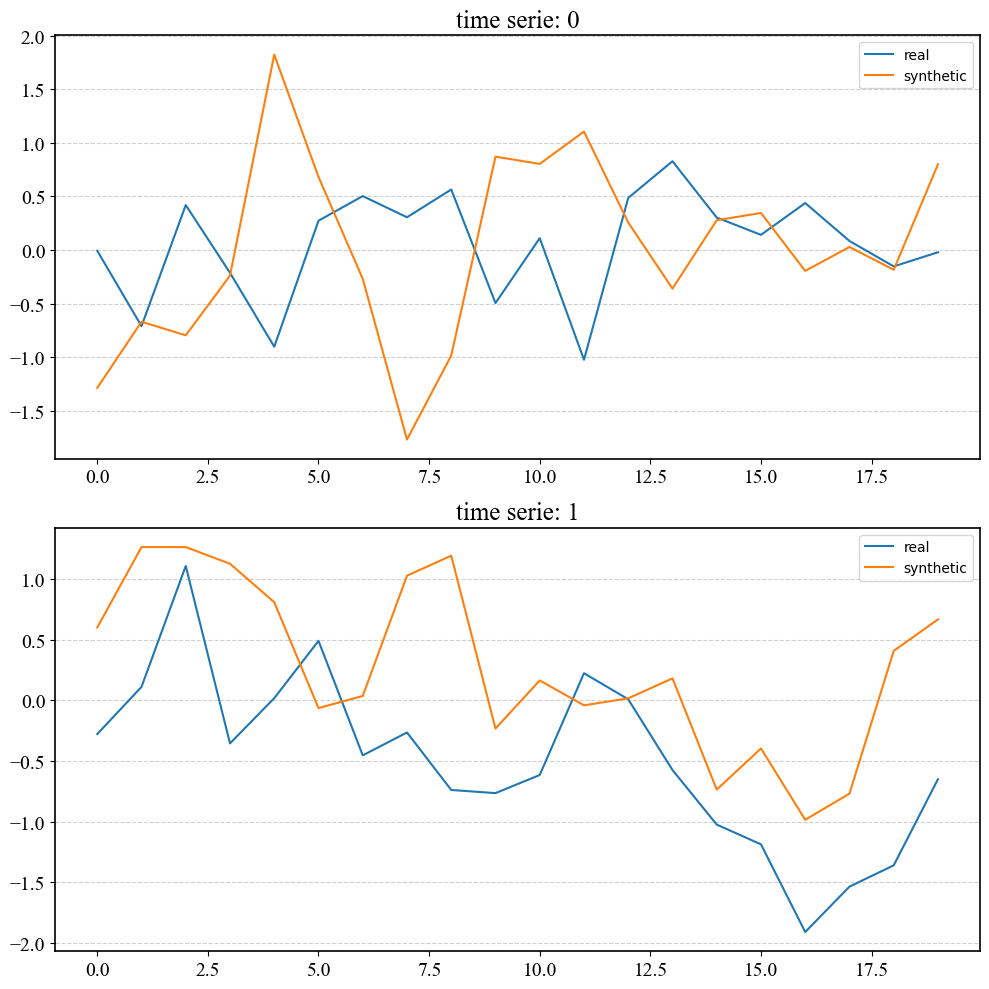

In [46]:
for i in np.random.choice(len(test_data), size=1):
    visualize_time_series(test_data[i], first_synthetic_data[i])

### Diversity

Do the generated samples cover the distribution of the real data?


To answer this question, we apply t-SNE or PCA to both the original and synthetic datasets (after flattening the temporal dimension). Here we project the data into 2-dimensional space, allowing us to visually assess how closely the distribution of the generated samples resembles that of the real data.

In [47]:
# get the first time series
test_single_series = test_data[..., 0]
synthetic_single_series = first_synthetic_data[..., 0]

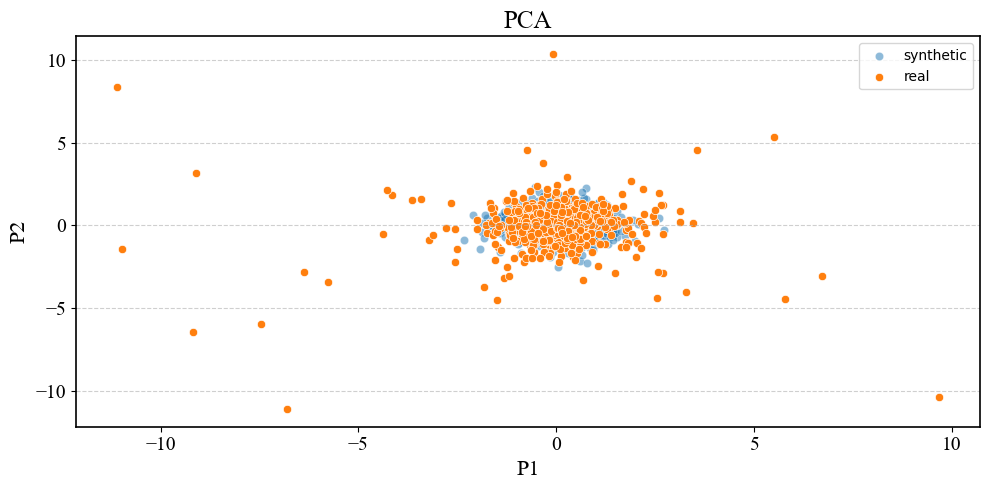

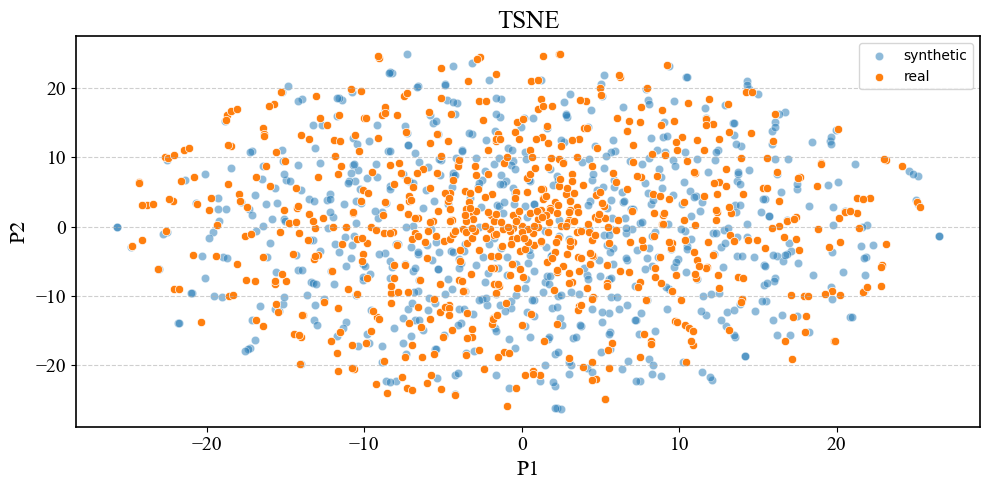

In [48]:
# Visualization of 2D PCA projection
visualize_2d_pca(test_single_series, synthetic_single_series)
# Visualization of 2D TSNE projection
visualize_2d_tsne(test_single_series, synthetic_single_series)

### Discriminative and Predictive Scores

- The **discriminative score** evaluates how well a classifier can distinguish real data from synthetic data by measuring metrics like accuracy.
  
- The **predictive score** measures how useful synthetic data is for forecasting tasks by training a model to predict the next value and comparing its performance to a model trained on real data.

For simplicity, we use a single-layer `LSTM` based architecture for both the classifier and the regressor, without any architecture search or hyperparameter tuning. More details can be found in the `EvaluationGenerativeModels.ipynb` notebook.

Below, we provide both scores

In [49]:
# compute scores
predictive_scores, discrimnative_scores = evaluate(
    test_data,
    synthetic_data_iters,
    random_state=ENV_CONFIG["random_state"],
    max_iters=DATA_CONFIG["num_eval_iterations"])

  0%|          | 0/50 [00:00<?, ?it/s]

Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpe98c_shi..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp96i91pjb..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp23rdr3vi..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp1qeu56mf..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpz8z9laq_..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpznsihwab..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpcr11iiud..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpulbavlmf..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnhb8e2pt..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp13ff_3ul..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmprbmjdc0a..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxv5n1n83..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp82h5c6_s..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp4adq1nmg..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmplvtbgrif..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp5o0byg_p..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmphz2mcfhg..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpgghn8l3i..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3cn3jei3..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp1n8p9m41..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp42df0r1q..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpwh727m85..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpyhpj7qy7..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp_e65b426..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpqkyezm7f..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0lz7fkus..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpn37co5ow..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpq6qsmr7r..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpdn48ttyj..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp6c2g5vh8..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmplq92rlv3..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpotlgb81g..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2g1hbptu..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmphm75hj5g..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpum3ntdbm..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpph6xpjwy..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpin2sf4v7..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp8wvl3xvh..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpmz0j9cmp..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpu_h2sao6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpegyb7lx9..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3vm95f1_..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp627jf5o_..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0ofql13p..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmph55bsc1o..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnnpc7dhq..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpa4y5khbd..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpx6fk359a..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp_bppbbi7..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpisl5tmm0..


`Trainer.fit` stopped: `max_steps=1000` reached.


  0%|          | 0/50 [00:00<?, ?it/s]

Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottle

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpgusg4dkl..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpvdi4vjdw..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpzr1qj704..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpt1q1jqg9..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3_h6fbci..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpiec6f66s..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmps88az1m7..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpd79ukgyt..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpujh2axvx..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpstzdk3is..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpn0zpulkk..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2cj2765p..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpz77n8ggt..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmplaq7qrwy..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpyss99r6l..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpdiua33bv..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpw6zkctnq..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp71i31dj9..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpbptjarnm..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpn6rvyep1..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0vcad5vc..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpif1l598n..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp9l5kije2..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmphsjk5i7l..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmplc3tpovi..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxsop5wz6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmprn6nevse..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpgnf987lj..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpiqj47t_3..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp012f8omy..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpfp2t9u3h..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpeh6vvplo..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpwgftmppn..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp5j4nfytb..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp54t7ibwy..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpvr0uub8_..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpl6txvygk..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp21rmm_jx..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0g28plnp..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpidwyial1..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpeyauv1qo..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpq6xo9wlq..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpuh9ti0_w..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpem6msgql..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpahm96s5m..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2jyx0zvh..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpfohti9dl..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0o156evz..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxoc3xnxy..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpwweag23w..


`Trainer.fit` stopped: `max_steps=1000` reached.


In [50]:
# Display the discriminative scores 
discrimnative_scores

,count,mean,std,min,25%,50%,75%,max
auc,50.0,0.882718,0.014364,0.847517,0.873635,0.882277,0.893196,0.914403
precision,50.0,0.840025,0.035311,0.766423,0.814669,0.841053,0.861111,0.933962
recall,50.0,0.729333,0.041017,0.614815,0.705556,0.733333,0.755556,0.814815
f1,50.0,0.779344,0.020686,0.726496,0.765432,0.781049,0.789760,0.821577
acc,50.0,0.793926,0.017125,0.762963,0.785185,0.792593,0.803704,0.840741


In [51]:
# Display the predictive scores 
predictive_scores

,count,mean,std,min,25%,50%,75%,max
MSE,50.0,0.893603,0.043054,0.827564,0.864531,0.886796,0.916143,1.024771
MAE,50.0,0.608653,0.011651,0.587989,0.602614,0.607580,0.613439,0.644863
MAPE,50.0,223.181121,27.396363,183.062410,202.942830,215.851808,236.971605,304.415512
